## $H \rightarrow \gamma \gamma $ Fitting (Without ROOT library)
This is an example of fitting the di-photon invariant mass to determine the number of Higgs signal events.
We have a data set consists of ~ 30000 di-photon invariant mass values from a tetx file (Hgg.txt) which should be in the current directory.

This program is different from the CERN ROOT project as we do not use ROOT library in here. There are some problems in implementation ROOT into python. As we need to set the PYTHONPATH and PYTHONDIR thorugh terminal/command. For those who want to compute the same result without using ROOT. This code may help you!

Our goal in this code is to use parameter estimation to find out the parameters in this model. The central spirit of Bayesian analysis is: Given the observed data, how likely that the model is true?

CERN Original Source: 
https://github.com/root-project/training/blob/master/BasicCourse/Exercises/ROOTBooks/HiggsBinFit.ipynb

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd 
import scipy as sp
import matplotlib.pyplot as plt 
from pymc3 import *  
import seaborn as sns 
sns.set_style("darkgrid")

Read the txt file to extract the data of $H \rightarrow \gamma \gamma $ 

In [2]:
higgs_data = pd.read_csv("Hgg.txt", names=["Higgs data"])
higgs_data.head()

,Higgs data
0,142.744
1,141.318
2,131.869
3,123.033
4,149.585


# Plot Higgs data using histogram

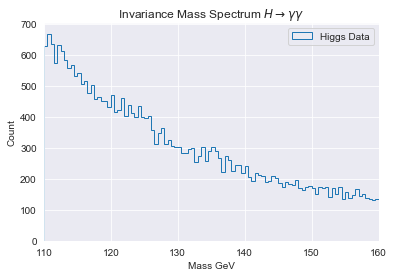

In [3]:
plt.title(r"Invariance Mass Spectrum $H \rightarrow \gamma \gamma$")
counts, bins,patches = plt.hist(higgs_data.values, bins=100,range=[110,160],histtype= "step" ,label="Higgs Data")
plt.xlabel(r"Mass GeV")
plt.ylabel("Count")
plt.xlim(110,160)
plt.legend()

# Model Creation
We assume a Gaussian distribution for the signal and a double exponential distribution for the background as following:

\begin{align}
P(x| \mu,\nu) = n_{sig} \times G(x|M,\sigma) + n_{bkg}\times E(x|a_{1}, a_{2}) 
\end{align}

where $G (x | M , \sigma)$ is the Gaussian distribution for the signal and $E(x|a_1,a_2)$ is the exponential distribution describing the background.

$$E(x|a_1,a_2) = \frac{ e^{( - a1 * x/100 - a2 * (x/100)^2 )}}{\int e^{-(.....)} dx }$$

In [4]:
def likelihood_model(x,A1,A2,mass,sigma,a1,a2):
    # Normalized Gaussian distribution
    f_sig = A1*np.exp(-0.5*((x- mass)/sigma)**2)/np.sqrt(2*np.pi*sigma**2)
    # Normalized exp distribution 
    f_bkg =  A2*np.exp(-(a1*x)/100-a2*(x/100)**2)
    # using rectangle rule to compute the integral;the factor(50/100) is delta_x in rectangle rule  
    norm_exp = np.array([np.exp(-(a1*x)/100-a2*(x/100)**2)*50/100 for x in x]).sum()
    return f_sig + f_bkg/norm_exp

In [5]:
x = np.linspace(110,160,100)
#f_test= likelihood_model(x,A1=138,A2=1.5E4,mass=124,sigma=1.49,a1=8.64,a2=-2.029)

# Build model for Bayesian inference 
Suppose we know nothing and assume that the distribution of those parameters are uniform. Them ,we build a model to estimate the parameters. We first use parameter estimation to find out the parameter in f_bkg as there are lots of data are backgroud signal, and it smooths the whole curve. After we fit the f_bkg, we have prior knowledge to set the prior of A2, a1, and a2. Therefore, we can have a better parameters estimation of the S+B signal.

In [6]:
with Model() as fbkg_model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = Uniform("sigma",0,500)
    A2 = Uniform("Amp2", 0, 50000)
    a1 = Uniform("a1", 0, 15)
    a2 = Uniform("a2",-5, 5)
    # Define likelihood
    likelihood = Normal("y",A2*np.exp(-(a1*x)/100-a2*(x/100)**2)/np.array([np.exp(-(a1*x)/100-a2*(x/100)**2)*50/100 for x in x]).sum(),
                        sigma=sigma, observed=counts)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a2, a1, Amp2, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:49<00:00, 45.84draws/s]
/Users/pangkachun/Library/Python/3.7/lib/python/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/pangkachun/Library/Python/3.7/lib/python/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/pangkachun/Library/Python/3.7/lib/python/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value wo

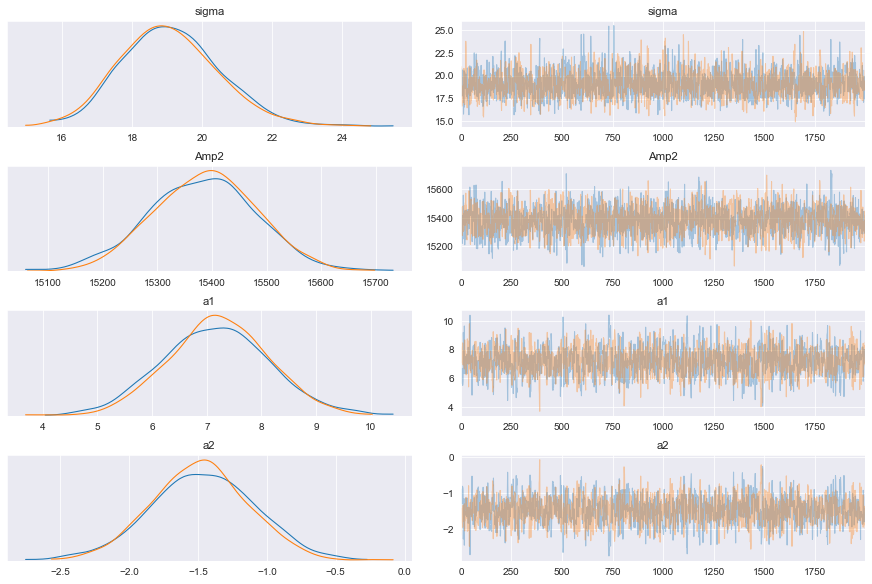

In [7]:
with fbkg_model:
    trace_fbkg_model = sample(2000, tune=500,cores=2)
    traceplot(trace_fbkg_model)

In [8]:
# Result of fbkg parameters
res_bkg = summary(trace_fbkg_model)
res_bkg

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma,19.088,1.410,16.599,21.753,0.030,0.021,2231.0,2218.0,2242.0,1933.0,1.0
Amp2,15384.295,96.052,15201.126,15562.181,2.262,1.600,1803.0,1803.0,1812.0,1859.0,1.0
a1,7.177,0.956,5.318,8.895,0.025,0.018,1428.0,1428.0,1436.0,1410.0,1.0
a2,-1.480,0.369,-2.128,-0.750,0.010,0.007,1429.0,1429.0,1437.0,1424.0,1.0


In [9]:
# model with both signal and background 

with Model() as SB_model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sd = Uniform("sigma",0,30)
    A1 = Uniform("Amp1", 0, 500)
    A2= Uniform("Amp2", 13000, 18000)
    mass =  Uniform("mass", 110, 160)
    sigma =  Uniform("std",0,5)
    a1 =  Uniform("a1", 5, 10)
    a2 = Uniform("a2", -5,0)
    # Define likelihood 
    likelihood = Normal("y",likelihood_model(x,A1,A2,mass,sigma,a1,a2),
                        sigma=sd, observed=counts)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a2, a1, std, mass, Amp2, Amp1, sigma]
Sampling 2 chains, 1 divergences: 100%|██████████| 7000/7000 [03:20<00:00, 34.96draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/Users/pangkachun/Library/Python/3.7/lib/python/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/pangkachun/Library/Python/3.7/lib/python/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/pangkachun/Library/Python/3.7/lib/python/site-packages/arviz/plots/backends/matplotlib/distplot.p

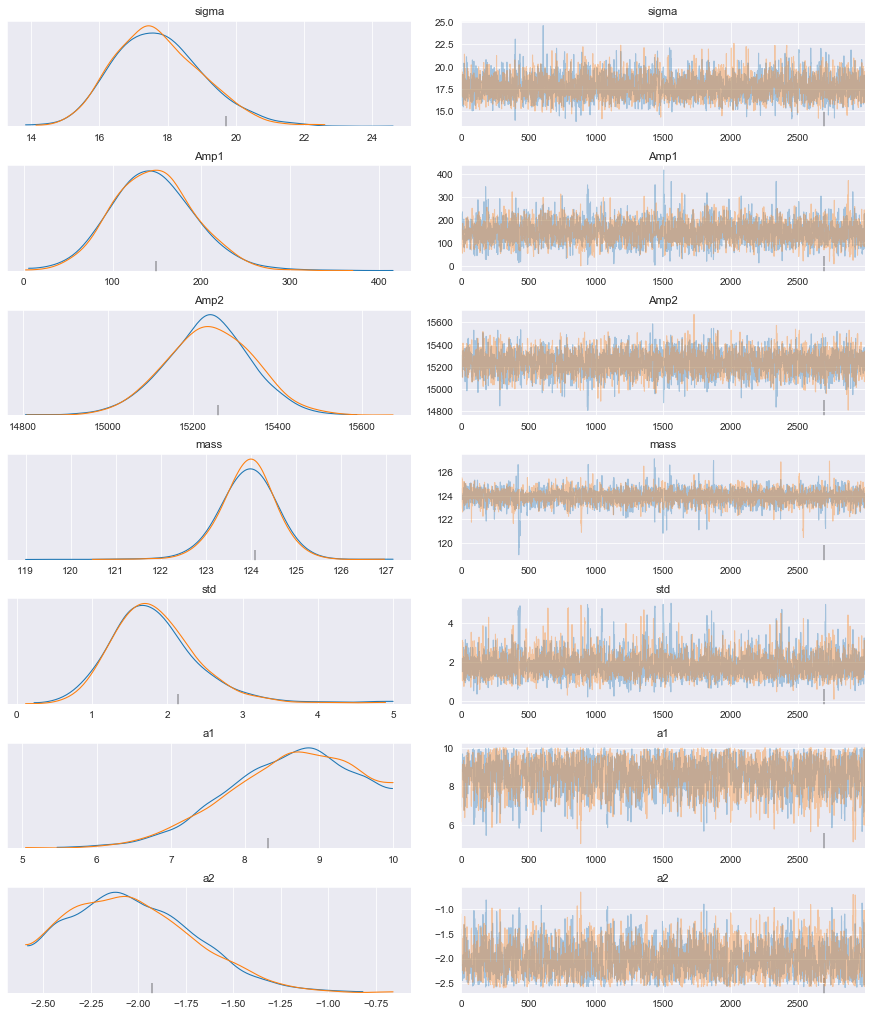

In [10]:
with SB_model:
    trace_SB_model = sample(3000,cores=2)
    traceplot(trace_SB_model)

In [11]:
#results of parameters estimatino
res_SB = summary(trace_SB_model)
res_SB

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma,17.752,1.302,15.437,20.238,0.023,0.016,3233.0,3172.0,3349.0,3005.0,1.0
Amp1,146.698,46.700,62.905,235.849,0.879,0.622,2823.0,2823.0,2818.0,2565.0,1.0
Amp2,15239.047,100.320,15046.355,15419.907,1.691,1.196,3521.0,3521.0,3546.0,3831.0,1.0
mass,123.940,0.617,122.841,125.069,0.012,0.009,2629.0,2629.0,3295.0,2357.0,1.0
std,1.863,0.625,0.832,3.035,0.013,0.010,2426.0,1846.0,3245.0,2133.0,1.0
a1,8.591,0.841,7.185,9.994,0.018,0.013,2098.0,2088.0,2056.0,2044.0,1.0
a2,-2.024,0.324,-2.568,-1.475,0.007,0.005,2113.0,2091.0,2062.0,2052.0,1.0


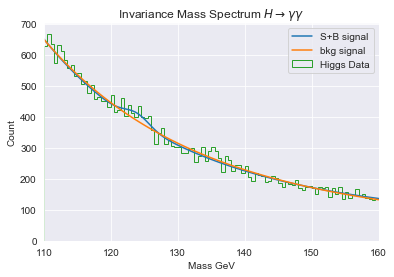

In [13]:
plt.title(r"Invariance Mass Spectrum $H \rightarrow \gamma \gamma$")
plt.plot(x,likelihood_model(x,A1=146.698,A2=15239.047,mass=123.940,sigma=1.863,a1=8.591,a2=-2.024),label="S+B signal")
plt.plot(x,15384.295*np.exp(-(7.177*x)/100-(-1.480)*(x/100)**2)/np.array([np.exp(-(7.177*x)/100-(-1.480)*(x/100)**2)*50/100 for x in x]).sum(), label="bkg signal")
counts, bins,patches = plt.hist(higgs_data.values, bins=100,range=[110,160],histtype= "step" ,label="Higgs Data")
plt.xlabel(r"Mass GeV")
plt.ylabel("Count")
plt.xlim(110,160)
plt.legend()

The little bump is what particle physicists looking for: the exitence of Higgs boson